# Patient Data Model usage example


This notebook contains example code that demonstrates how to:
* load a tabular dataset into the patient data model
* query the data model to get the data out in table format
* create a dataset and an experiment
* load the experiment results into the inductive database
* create a new dataset from the results

Most of the exposed calls to the database used in this example (e.g. SQL queries to fetch data out of the model) will in future versions be abstracted through an API.

## Import the required modules

In [1]:
import psycopg2
import pandas
import numpy
import datetime
import dateutil
import os
import sys
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas.io.sql as pdsql

sys.path.insert(0, '../')

from patient_data_model import model
from patient_data_model.vocabulary import CommonVocabulary, VariableDefinition
from patient_data_model import postgres
from patient_data_model import util

from sklearn.cluster import KMeans

## Initiate a connection to the patient data model storage
The patient data model will be stored in a persistent database. First we need to initiate a connection to a storage backend by creating an instance of DataModelStorage. We will use a Postgres as storage backend, using the PostgresDataModelStorage class.

In [2]:
data_model_storage = postgres.PostgresDataModelStorage()
data_model_storage.open('host=postgres dbname=postgres user=test password=test')
data_model_storage.clear_database() # Start this example with a clean database

## Import a dataset
This part of the notebook shows how to import a tabular dataset into the data model.

An example dataset is used (see 'examples/example_data.tsv') that contains mocked data from two studies (Study_X and Study_Y). Each study has one or more visits on which measurements form a patient were taken, described in the 'visit' and 'dvisit' columns. Each row represents datapoints on a specific patient, identified by the 'idnr' column. The other columns contain features, measurements, and events for each patient.

### Load the cohort data

In [3]:
## Load the cohort data
cohort_data = pandas.read_csv('example_data.tsv', sep='\t', index_col = None)
cohort_data.head()

idnr     visit    study  sex  dvisit  age  bw  smk  undescribed_variable  \
0     1  Baseline  Study_X    1   15147   70  54    1                     0   
1     1   Visit 1  Study_X    1   16189   57  78    2                     1   
2     2  Baseline  Study_X    1   15369   80  57    2                     0   
3     2   Visit 1  Study_X    1   16187   67  69    0                     1   
4     3  Baseline  Study_X    1   15369   66  54    1                     1   

   diabetes  bnp  nyha  death  
0         0    0     3      0  
1         0    9     3      0  
2         1    7     2      0  
3         1    3     2      1  
4         1    3     1      0

### Preprocess the cohort data
In the following steps, the tabular data is cleaned up and properly formatted to prepare it for import.

In [4]:
## Parse dates to a Python date object
cohort_data['dvisit'] = pandas.to_timedelta(cohort_data['dvisit'], unit='D') + pandas.Timestamp('1960-1-1')

## Reformat the sex variable
cohort_data.replace({'sex': {1.0: 'http://schema.org/Male', 2.0: 'http://schema.org/Female'}}, inplace=True)
cohort_data.replace({'smk': {0.0: 'no', 1.0: 'yes', 2.0: 'ex-smoker'}}, inplace=True)

## Add a row identifier to build the datapoint URI
cohort_data['row_id'] = [i for i in range(len(cohort_data))]

## Cast boolean columns
boolean_cols =['diabetes', 'death']
for col in boolean_cols:
    cohort_data[col] = cohort_data[col].astype('bool')
    
cohort_data.head()

idnr     visit    study                     sex     dvisit  age  bw  \
0     1  Baseline  Study_X  http://schema.org/Male 2001-06-21   70  54   
1     1   Visit 1  Study_X  http://schema.org/Male 2004-04-28   57  78   
2     2  Baseline  Study_X  http://schema.org/Male 2002-01-29   80  57   
3     2   Visit 1  Study_X  http://schema.org/Male 2004-04-26   67  69   
4     3  Baseline  Study_X  http://schema.org/Male 2002-01-29   66  54   

         smk  undescribed_variable  diabetes  bnp  nyha  death  row_id  
0        yes                     0     False    0     3  False       0  
1  ex-smoker                     1     False    9     3  False       1  
2  ex-smoker                     0      True    7     2  False       2  
3         no                     1      True    3     2   True       3  
4        yes                     1      True    3     1  False       4

## Map the variables to a common vocabulary
Before loading in the data, the columns in the table need to be mapped to a common vocabulary. The patient data model can store the common vocabulary along with the data.

Since we start with an empty patient data model, we will need to define the vocabulary from scratch before importing any data. In case of an existing patient data model, the stored vocabulary can be obtained using the *DataModelStorage.get_common_vocabulary* method.

In [5]:
vocabulary = CommonVocabulary()

## Create a vocabulary variable for 'sex', following the schema.org definition
## This will map to the column 'sex' in cohort_data
var = VariableDefinition(
    uri = 'http://schema.org/Gender',
    name = 'Gender',
    description = 'The gender of the subject',
    xsd_type = 'xsd:string'
)
var.set_allowed_values(['http://schema.org/Male', 'http://schema.org/Female'])
vocabulary.add_definition(var)

## Create a vocabulary variable for 'age', following the experimental factor ontology definition
## This will map to the column 'age' in cohort_data
var = VariableDefinition(
    uri = 'http://www.ebi.ac.uk/efo/EFO_0000246',
    name = 'Age',
    description = 'The age of the subject',
    xsd_type = 'xsd:decimal'
)
var.set_allowed_units(['years']) ## Specify that age should be provided in years
vocabulary.add_definition(var)

## Create a vocabulary variable for 'body weight', following the experimental factor ontology definition
## This will map to the column 'bw' in cohort_data
var = VariableDefinition(
    uri = 'http://www.ebi.ac.uk/efo/EFO_0004338',
    name = 'Body Weight',
    description = 'The body weight of the subject',
    xsd_type = 'xsd:decimal'
)
var.set_allowed_units(['kg']) ## Specify that age should be provided in kilograms
vocabulary.add_definition(var)

## Create a vocabulary variable for 'smoking status', following the experimental factor ontology definition
## This will map to the column 'smk' in cohort_data
var = VariableDefinition(
    uri = 'http://www.ebi.ac.uk/efo/EFO_0004318',
    name = 'Smoking status',
    description = 'The smoking status of the subject',
    xsd_type = 'xsd:string'
)
var.set_allowed_values(['no', 'yes', 'ex-smoker']) ## Specify that age should be provided in kilograms
vocabulary.add_definition(var)

## Create a vocabulary variable for 'History of diabetes'
## This is an internal variable (not using an external ontology to define it), hence the internal URI
## This will map to the column 'diabetes' in cohort_data
var = VariableDefinition(
    uri = 'http://my-patient-data-model/history-of-diabetes',
    name = 'History of Diabetes',
    description = 'Whether the patient has a history of Diabetes',
    xsd_type = 'xsd:boolean'
)
## Add mappings to diabetes concepts in other resources to enable integration with knowledge resources
var.set_mappings([
    'http://purl.obolibrary.org/obo/DOID_9351', 
    'http://purl.bioontology.org/ontology/SNOMEDCT/73211009'
]) 
vocabulary.add_definition(var)

## Create a vocabulary variable for 'BNP', following the experimental factor ontology definition
## This will map to the column 'bnp' in cohort_data
var = VariableDefinition(
    uri = 'http://www.ebi.ac.uk/efo/EFO_0006920',
    name = 'BNP measurement',
    description = 'The BNP level of the subject',
    xsd_type = 'xsd:string'
)
var.set_allowed_units(['pg/mL'])
## Add mappings to the BNP protein to enable integration with the molecular knowledgebase
var.set_mappings([
    'http://identifiers.org/uniprot/P16860'
])
vocabulary.add_definition(var)

## Create a vocabulary variable for 'NYHA', following the SNOMEDCT ontology definition
## This will map to the column 'nyha' in cohort_data
var = VariableDefinition(
    uri = 'http://purl.bioontology.org/ontology/SNOMEDCT/420816009',
    name = 'NYHA',
    description = 'New York Heart Association Classification score',
    xsd_type = 'xsd:integer'
)
var.set_allowed_values([1,2,3,4])
vocabulary.add_definition(var)

## Create a vocabulary variable for 'death', following the experimental factor ontology definition
## This will map to the column 'death' in cohort_data
var = VariableDefinition(
    uri = 'http://www.ebi.ac.uk/efo/EFO_0000480',
    name = 'Death',
    description = 'Event of death of the subject',
    xsd_type = 'xsd:boolean'
)
vocabulary.add_definition(var)

Note that one variable column from cohort_data was not defined in the vocabulary (column 'undescribed_variable'). This is to demonstrate that variables that are not part of the common vocabulary can still be imported (see next step) if desired. The implication of not mapping a variable to the common vocabulary is that they will not be included in any integrated table views and will be harder to integrate with other cohorts.

The resulting vocabulary now has the following structure:

In [6]:
print(json.dumps(vocabulary.to_dict(), indent=2))

{
  "http://schema.org/Gender": {
    "uri": "http://schema.org/Gender",
    "name": "Gender",
    "description": "The gender of the subject",
    "xsd_type": "xsd:string",
    "allowed_values": [
      "http://schema.org/Male",
      "http://schema.org/Female"
    ]
  },
  "http://www.ebi.ac.uk/efo/EFO_0000246": {
    "uri": "http://www.ebi.ac.uk/efo/EFO_0000246",
    "name": "Age",
    "description": "The age of the subject",
    "xsd_type": "xsd:decimal",
    "allowed_units": [
      "years"
    ]
  },
  "http://www.ebi.ac.uk/efo/EFO_0004338": {
    "uri": "http://www.ebi.ac.uk/efo/EFO_0004338",
    "name": "Body Weight",
    "description": "The body weight of the subject",
    "xsd_type": "xsd:decimal",
    "allowed_units": [
      "kg"
    ]
  },
  "http://www.ebi.ac.uk/efo/EFO_0004318": {
    "uri": "http://www.ebi.ac.uk/efo/EFO_0004318",
    "name": "Smoking status",
    "description": "The smoking status of the subject",
    "xsd_type": "xsd:string",
    "allowed_values": [
   

Now we can store the controlled vocabulary in the data model storage to persist it for subsequent imports.

In [7]:
data_model_storage.store_common_vocabulary(vocabulary)

### Import the data
Now the cohort data is ready to be imported into the patient data model. The following code iterates over the rows of the table, maps columns to subject, study, timepoint, feature, measurement, or event, and stores the datapoints into the model.

In [8]:
cohort_uri = 'http://my-patient-data-model/test-cohort'
subject_column = 'idnr'
row_id_column = 'row_id'
study_column = 'study'
visit_label_column = 'visit'
visit_date_column = 'dvisit'

## Define mappings for each column to a measurement,feature,event and a variable URI
column_mappings = {
    'sex': ('feature', 'http://schema.org/Gender'),
    'age': ('measurement', 'http://www.ebi.ac.uk/efo/EFO_0000246', 'years'),
    'bw': ('measurement', 'http://www.ebi.ac.uk/efo/EFO_0004338', 'kg'),
    'smk': ('measurement', 'http://www.ebi.ac.uk/efo/EFO_0004318'),
    'undescribed_variable': ('measurement', '%s/variables/undescribed_variable' % cohort_uri),
    'diabetes': ('feature', 'http://my-patient-data-model/history-of-diabetes'),
    'bnp': ('measurement', 'http://www.ebi.ac.uk/efo/EFO_0006920', 'pg/mL'),
    'nyha': ('measurement', 'http://purl.bioontology.org/ontology/SNOMEDCT/420816009'),
    'death': ('event', 'http://www.ebi.ac.uk/efo/EFO_0000480'),
}

## Iterate over each row and import the corresponding data
for index, row in tqdm(cohort_data.iterrows(), total=len(cohort_data)):
    ## Add the subject
    subject = model.Subject(uri = '%s/%s' % (cohort_uri, row[subject_column]))
    data_model_storage.store_subject(subject, conflict_action = 'ignore')

    ## Add the study
    study = model.Study(
        uri = '%s/%s' % (cohort_uri, row[study_column]), 
        name = row[study_column]
    )
    data_model_storage.store_study(study, conflict_action = 'ignore')

    ## Add timepoint
    timepoint = model.Timepoint(
        uri = '%s/timepoint/%s/%s' % (study.uri, row[visit_label_column], row[visit_date_column])
    )
    timepoint.set_label(row[visit_label_column])
    timepoint.set_date(row[visit_date_column])
    data_model_storage.store_timepoint(timepoint, conflict_action = 'ignore')
    
    ## Add features, measurements, and events
    for col,mappings in column_mappings.items():
        if pandas.isnull(row[col]):
            continue ## Don't import NaN / null values
        
        # Generate an URI for this cell in the table, based on base uri, row id, and column
        uri = '%s/%s/%s' % (cohort_uri, row[row_id_column], col)
        
        # Try to find the variable definition in the vocabulary
        variable = vocabulary.get_definition(mappings[1])
        # If it is not present, we decide to add it based on only the URI
        # (here it is up to the user whether to ignore the datapoint, 
        # extend the vocabulary, or add without vocabulary definition)
        if variable is None:
            variable = mappings[1]
        
        # Generate the datapoint object of the type specified in the mapping definition
        if mappings[0] == 'feature':
            feature = model.Feature(uri, variable, study.uri, subject.uri, timepoint.uri)
            feature.set_value(row[col])
            data_model_storage.store_feature(feature)
        if mappings[0] == 'measurement':
            measurement = model.Measurement(uri, variable, study.uri, subject.uri, timepoint.uri)
            measurement.set_value(row[col])
            if len(mappings[1]) == 3: # Unit was specified
                measurement.set_unit(mappings[1][2])
                
            data_model_storage.store_measurement(measurement)
        if mappings[0] == 'event':
            event = model.Event(uri, variable, study.uri, subject.uri, timepoint.uri)
            event.set_value(row[col])
            data_model_storage.store_event(event)
            

100%|██████████| 927/927 [00:05<00:00, 169.40it/s]


In [9]:
data_model_storage.flush() ## Make sure all transactions are committed

The common vocabulary in the data model makes it possible to prepare tabular views on the data, for example integrating all variables from the vocabulary in a single table and casting the values to the apropriate types (using the xsd_type attribute from the vocabulary). This view can then be queried like any SQL table, for example to quickly obtain a dataframe for a single timepoint.

The Patient Data Model Dashboard makes heavy use of this view, so after importing the data or changing the vocabulary, always re-create the view using the following function:

In [10]:
util.create_view_for_datapoints(data_model_storage.db, 'integrated_datapoint_table', True)

## Data model usage examples
Now the cohort data has been imported, we can extracted the integrated data from the patient data model.

In future versions, based on actual use cases to be developed, querying functionality will be abstracted and implemented in the DataModelStorage API using methods such as "get_json_data(study, variable)", "get_integrated_data_table()", etc.

For now, the following code interacts with the Postgres database directly, to illustrate the rationale behind the way the data model stores the data: it allows for ultimate flexibility. Datapoints can be queried as json, as tables, and views can be created to obtain integrated tabular versions of multiple cohort datasets based on the common vocabulary.

In [11]:
## Connect to the database that contains the data model
conn = psycopg2.connect("host=postgres dbname=postgres user=test password=test")

Obtain the body weight for a given subject in a given study as json. This type of query will be most useful to build web applications on top of the data model.

In [12]:
query = """
SELECT json FROM datapoint
WHERE
    datapoint.json->>'subject' = 'http://my-patient-data-model/test-cohort/1' AND
    datapoint.json->>'variable' = 'http://www.ebi.ac.uk/efo/EFO_0004338' AND
    datapoint.json->>'study' = 'http://my-patient-data-model/test-cohort/Study_X'
"""

with conn:
    with conn.cursor() as cur:
        cur.execute(query)
        print(json.dumps(cur.fetchone()[0], indent = 2))

{
  "uri": "http://my-patient-data-model/test-cohort/0/bw",
  "type": "measurement",
  "study": "http://my-patient-data-model/test-cohort/Study_X",
  "value": 54,
  "subject": "http://my-patient-data-model/test-cohort/1",
  "variable": "http://www.ebi.ac.uk/efo/EFO_0004338",
  "timepoint": "http://my-patient-data-model/test-cohort/Study_X/timepoint/Baseline/2001-06-21 00:00:00"
}


We can also get the body weight for all subjects, studies, and timepoints, in a tabular format.

In [13]:
query = """
SELECT
    datapoint.json->>'subject' AS subject, 
    study.json->>'name' AS study, 
    timepoint.json->>'label' AS timepoint_label,
    timepoint.json->>'date' AS timepoint_date, 
    CAST(datapoint.json->>'value' AS float) AS bodyweight
        FROM datapoint, timepoint, study
            WHERE
                datapoint.json->>'variable' = 'http://www.ebi.ac.uk/efo/EFO_0004338' AND 
                timepoint.uri = datapoint.json->>'timepoint' AND
                study.uri = datapoint.json->>'study'
"""

df = pdsql.read_sql_query(query, conn)
df.head()

subject    study timepoint_label  \
0  http://my-patient-data-model/test-cohort/1  Study_X        Baseline   
1  http://my-patient-data-model/test-cohort/1  Study_X         Visit 1   
2  http://my-patient-data-model/test-cohort/2  Study_X        Baseline   
3  http://my-patient-data-model/test-cohort/2  Study_X         Visit 1   
4  http://my-patient-data-model/test-cohort/3  Study_X        Baseline   

        timepoint_date  bodyweight  
0  2001-06-21T00:00:00        54.0  
1  2004-04-28T00:00:00        78.0  
2  2002-01-29T00:00:00        57.0  
3  2004-04-26T00:00:00        69.0  
4  2002-01-29T00:00:00        54.0

Such a table is handy for quickly visualizing summary statistics, such as the example below.

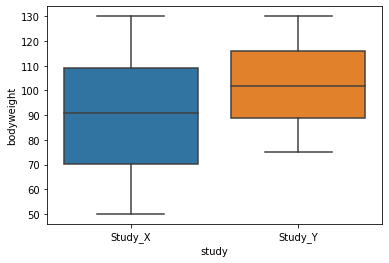

In [14]:
p = sns.boxplot(x = 'study', y = 'bodyweight', data = df)

The integrated_datapoint_table is a view on the more abstract datapoint and vocabulary tables that is convenient to query if you simply want to obtain a patient by variable format for downstream analyses and data exploration. For example investigating if there are any groupwise differences for a variable.

In [15]:
df = pdsql.read_sql_query("""
    SELECT * FROM integrated_datapoint_table
    WHERE timepoint_label = 'Baseline'
""", conn)
df.head()

row_name  \
0  http://my-patient-data-model/test-cohort/100ht...   
1  http://my-patient-data-model/test-cohort/101ht...   
2  http://my-patient-data-model/test-cohort/102ht...   
3  http://my-patient-data-model/test-cohort/103ht...   
4  http://my-patient-data-model/test-cohort/104ht...   

                                        subject  \
0  http://my-patient-data-model/test-cohort/100   
1  http://my-patient-data-model/test-cohort/101   
2  http://my-patient-data-model/test-cohort/102   
3  http://my-patient-data-model/test-cohort/103   
4  http://my-patient-data-model/test-cohort/104   

                                              study study_name  \
0  http://my-patient-data-model/test-cohort/Study_X    Study_X   
1  http://my-patient-data-model/test-cohort/Study_X    Study_X   
2  http://my-patient-data-model/test-cohort/Study_X    Study_X   
3  http://my-patient-data-model/test-cohort/Study_X    Study_X   
4  http://my-patient-data-model/test-cohort/Study_X    Study_X   

                                           timepoint       timepoint_date  \
0  http://my-patient-data-model/test-cohort/Study...  2003-02-17T00:00:00   
1  http://my-patient-data-model/test-cohort/Study...  2003-03-25T00:00:00   
2  http://my-patient-data-model/test-cohort/Study...  2003-03-24T00:00:00   
3  http://my-patient-data-model/test-cohort/Study...  2003-03-27T00:00:00   
4  http://my-patient-data-model/test-cohort/Study...  2003-05-12T00:00:00   

  timepoint_label  http://schema.org/Gender  \
0        Baseline    http://schema.org/Male   
1        Baseline    http://schema.org/Male   
2        Baseline  http://schema.org/Female   
3        Baseline    http://schema.org/Male   
4        Baseline    http://schema.org/Male   

   http://www.ebi.ac.uk/efo/EFO_0000246  http://www.ebi.ac.uk/efo/EFO_0000480  \
0                                  89.0                                 False   
1                                  63.0                                 False   
2                                  71.0                                 False   
3                                  67.0                                 False   
4                                  56.0                                 False   

  http://www.ebi.ac.uk/efo/EFO_0006920  \
0                                    1   
1                                    1   
2                                    1   
3                                    1   
4                                    8   

   http://my-patient-data-model/history-of-diabetes  \
0                                             False   
1                                             False   
2                                              True   
3                                             False   
4                                             False   

  http://www.ebi.ac.uk/efo/EFO_0004318  \
0                                   no   
1                            ex-smoker   
2                            ex-smoker   
3                            ex-smoker   
4                                  yes   

   http://purl.bioontology.org/ontology/SNOMEDCT/420816009  \
0                                                  1         
1                                                  4         
2                                                  3         
3                                                  2         
4                                                  3         

   http://www.ebi.ac.uk/efo/EFO_0004338  
0                                  97.0  
1                                 127.0  
2                                 117.0  
3                                 120.0  
4                                  53.0

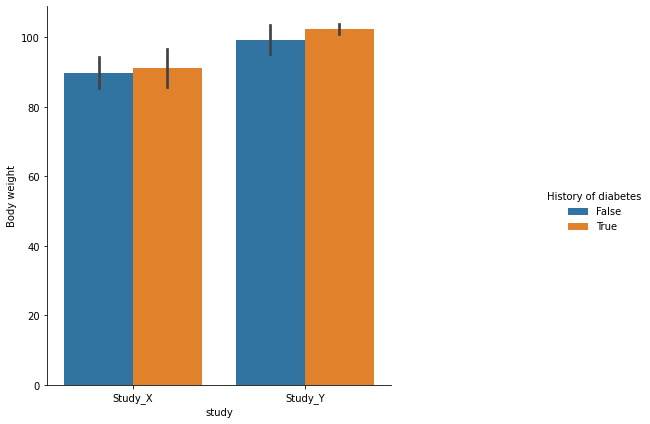

In [16]:
df['study'] = df['study'].apply(lambda x: x.replace('http://my-patient-data-model/test-cohort/', ''))
g = sns.catplot(x="study", y="http://www.ebi.ac.uk/efo/EFO_0004338", hue="http://my-patient-data-model/history-of-diabetes", data=df, height=6, kind="bar")

g.set(ylabel='Body weight')
g._legend.set_title("History of diabetes")

## Inductive part
### Dataset

In [17]:
uri = "http://my-patient-data-model/dataset/example"
name = "example"
description = "example dataset"
variables =['http://www.ebi.ac.uk/efo/EFO_0004338', 'http://www.ebi.ac.uk/efo/EFO_0000246', 'http://www.ebi.ac.uk/efo/EFO_0006920']
subjects = list(pdsql.read_sql_query("""
    SELECT subject FROM integrated_datapoint_table
    WHERE timepoint_label = 'Baseline' and "http://www.ebi.ac.uk/efo/EFO_0004338" > 80
""", conn)["subject"].values)
example_dataset = model.Dataset(uri, name, description, subjects, variables)
data_model_storage.store_dataset(example_dataset, conflict_action = 'ignore')

#### Extract data from the dataset

In [18]:
var = '","'.join(variables)
data =  pdsql.read_sql_query(f"""
    SELECT subject, "{var}" FROM integrated_datapoint_table
    WHERE timepoint_label = 'Baseline' and "http://www.ebi.ac.uk/efo/EFO_0004338" > 80
""", conn)

### Experiment

In [19]:
uri = "http://my-patient-data-model/experiment/example"
dataset = "http://my-patient-data-model/dataset/example"
program = "kmeans"
parameters = {"k":4}
metrics = {}
date = "09-03-21"

example_experiment = model.Experiment(uri, dataset, program, parameters, metrics, date)
data_model_storage.store_experiment(example_experiment, conflict_action = 'ignore')

In [20]:
data_model_storage.flush()

#### Clustering

In [21]:
y = data["subject"].values
X = data[variables]

clusters={0:[], 1:[], 2:[], 3:[],}
kmeans = KMeans(n_clusters=4).fit(X)
for i in range(len(y)):
    clusters[kmeans.labels_[i]].append(y[i])

### Insert clustering results

In [22]:
for cluster in clusters:
    uri = f"http://my-patient-data-model/experiment/example/cluster{cluster}"
    description = f"cluster {cluster}"
    experiment = "http://my-patient-data-model/experiment/example"
    subjects = clusters[cluster]
    example_cluster = model.Cluster(uri, experiment, description, subjects)
    data_model_storage.store_cluster(example_cluster, conflict_action = 'ignore')
data_model_storage.flush()


### Creation of a new dataset from the clustering results

In [23]:
uri = "http://my-patient-data-model/dataset/example"
name = "example2"
description = "example dataset 2 built from results of experiment http://my-patient-data-model/experiment/example"
variables =['http://schema.org/Gender', 'http://my-patient-data-model/history-of-diabetes']
subjects = numpy.array2string((pdsql.read_sql_query("""
    SELECT json->> 'subjects' as subjects FROM cluster
    WHERE uri = 'http://my-patient-data-model/experiment/example/cluster1'
""", conn)["subjects"].values))[4:-4].split('", "')
example_dataset = model.Dataset(uri, name, description, subjects, variables)
data_model_storage.store_dataset(example_dataset, conflict_action = 'ignore')

In [24]:
json.loads(example_dataset.to_json())

{'uri': 'http://my-patient-data-model/dataset/example',
 'name': 'example2',
 'description': 'example dataset 2 built from results of experiment http://my-patient-data-model/experiment/example',
 'subjects': ['http://my-patient-data-model/test-cohort/101',
  'http://my-patient-data-model/test-cohort/103',
  'http://my-patient-data-model/test-cohort/113',
  'http://my-patient-data-model/test-cohort/122',
  'http://my-patient-data-model/test-cohort/130',
  'http://my-patient-data-model/test-cohort/131',
  'http://my-patient-data-model/test-cohort/140',
  'http://my-patient-data-model/test-cohort/152',
  'http://my-patient-data-model/test-cohort/155',
  'http://my-patient-data-model/test-cohort/158',
  'http://my-patient-data-model/test-cohort/20',
  'http://my-patient-data-model/test-cohort/28',
  'http://my-patient-data-model/test-cohort/29',
  'http://my-patient-data-model/test-cohort/31',
  'http://my-patient-data-model/test-cohort/35',
  'http://my-patient-data-model/test-cohort/36',